# Supernovae simulation

## Imports

In [8]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
from importlib import import_module
import yaml
import pprint
import os
import numpy as np
from sn_tools.sn_io import check_get_file

## Choose parameters for the simulation

In [9]:
configFile = '../input/simulation/param_simulation_example.yaml'
config = yaml.load(open(configFile),Loader=yaml.FullLoader) #configuration dict - mandatory for the run

In [10]:
pprint.pprint(config) 

{'Cosmology': {'H0': 72.0,
               'Model': 'w0waCDM',
               'Ol': 0.7,
               'Om': 0.3,
               'w0': -1.0,
               'wa': 0.0},
 'Display': {'LC': {'display': 0, 'time': 5.0}},
 'Host': 0,
 'Instrument': {'aerosol': 0,
                'airmass': 1.2,
                'atmos': 1,
                'atmosDir': 'THROUGHPUTS_DIR',
                'name': 'LSST',
                'throughputDir': 'LSST_THROUGHPUTS_BASELINE'},
 'Multiprocessing': {'nproc': 1},
 'Observations': {'coadd': 1,
                  'fieldname': 'all',
                  'fieldtype': 'WFD',
                  'filename': '../DB_Files/descddf_v1.4_10yrs.npy',
                  'season': -1},
 'Output': {'directory': 'Output_Simu', 'save': 1},
 'Pixelisation': {'nside': 64},
 'ProductionID': 'prodid',
 'ReferenceFiles': {'DustCorrDir': 'Template_Dust',
                    'GammaDir': 'reference_files',
                    'GammaFile': 'gamma.hdf5',
                    'TemplateDir': 'T

## dbFile choice

In [11]:
dbName = 'descddf_v1.4_10yrs.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion

## Define slicer

In [12]:
slicer = slicers.HealpixSlicer(nside=config['Pixelisation']['nside'])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## check whether X0_norm file exist or not (and generate it if necessary)

In [13]:
absMag = config['SN']['absmag']
salt2Dir = config['SN']['salt2Dir']
model = config['Simulator']['model']
version = str(config['Simulator']['version'])

x0normFile = '../reference_files/X0_norm_{}.npy'.format(absMag)

if not os.path.isfile(x0normFile): 
    check_get_file(config['WebPath'],'reference_files','X0_norm_{}.npy'.format(absMag))


#if not os.path.isfile(x0normFile):
#    print('{} does not exist and is mandatory to run simulations -> will be created'.format(x0normFile))
#    from sn_tools.sn_utils import X0_norm
#    X0_norm(salt2Dir=salt2Dir,model=model, version=version, absmag=absMag,outfile=x0normFile)

x0_tab = np.load(x0normFile)

## Simulator instance

In [14]:
# Simulator instance
from sn_simu_wrapper.sn_simu import SNSimulation
metric = SNSimulation(config=config,x0_norm=x0_tab)

## Make the bundle

In [15]:
bundleList = []

sql = ''
sql = '(note = "%s")' %('DD:COSMOS')
#sql += ' OR (note = "%s")' %('DD:ELAISS1')
#sql += ' OR (note = "%s")' %('DD:ECDFS')
#sql += ' OR (note = "%s")' %('DD:XMM-LSS')
#sql += ' OR (note = "%s")' %('DD:290')

print(sql)
bundleList.append(metricBundles.MetricBundle(metric, slicer,sql,runName=dbName))
print(len(bundleList))

(note = "DD:COSMOS")
1


## Run! 

In [16]:
outDir = '{}_Simulation'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint (note = "DD:COSMOS") for columns ['observationId', 'visitExposureTime', 'fieldRA', 'visitTime', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'moonPhase', 'fieldDec', 'numExposures', 'airmass', 'filter', 'night', 'seeingFwhmGeom']
Found 27245 visits
Running:  ['descddf_v1_4_10yrs_db_SNSimulation_note_DD_COSMOS_HEAL']
Creating output directory Output_Simu
processing pixel 27347
processing pixel 27348
processing pixel 27346
processing pixel 27345
processing pixel 27262
processing pixel 27344
processing pixel 27259
processing pixel 27260
processing pixel 27333
processing pixel 27257
processing pixel 27247
processing pixel 27251
processing pixel 27246
processing pixel 27250
processing pixel 27244
processing pixel 27239
processing pixel 27248
processing pixel 27238
processing pixel 27237
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Output

In [17]:
ls Output_Simu

LC_prodid_1.hdf5  Simu_prodid_1.hdf5


Two files are generated:
- Simu_*.hdf5: summary of the generated LC = list of parameters used for generation
- LC_*.hdf5: light curves 

## Output analysis

In [18]:
%matplotlib notebook
import matplotlib.pylab as plt
import h5py
import numpy as np
from astropy.table import Table,vstack

### Parameter file

In [19]:
paramFile = '{}/Simu_{}_1.hdf5'.format(config['Output']['directory'],config['ProductionID'])
f = h5py.File(paramFile, 'r')
print(f.keys(),len(f.keys()))
params = Table()
for i, key in enumerate(f.keys()):
    params = vstack([params,Table.read(paramFile, path=key)])
    
# params is an astropy table
print(params[:10])
print(type(params),params.dtype)

<KeysViewHDF5 ['summary_27238', 'summary_27239', 'summary_27244', 'summary_27246', 'summary_27247', 'summary_27248', 'summary_27250', 'summary_27251', 'summary_27257', 'summary_27259', 'summary_27260', 'summary_27262', 'summary_27333', 'summary_27344', 'summary_27345', 'summary_27346', 'summary_27347', 'summary_27348']> 18
SNID               index_hdf5               ... epsilon_color epsilon_daymax
---- -------------------------------------- ... ------------- --------------
 174 27238_0.01_59947.5183_1_174_-2.0_0.2_0 ...           0.0            0.0
 175 27238_0.01_60304.5164_2_175_-2.0_0.2_0 ...           0.0            0.0
 176 27238_0.01_60687.4868_3_176_-2.0_0.2_0 ...           0.0            0.0
 177 27238_0.01_61052.4767_4_177_-2.0_0.2_0 ...           0.0            0.0
 178 27238_0.01_61417.4934_5_178_-2.0_0.2_0 ...           0.0            0.0
 179 27238_0.01_61776.4969_6_179_-2.0_0.2_0 ...           0.0            0.0
 180 27238_0.01_62146.4959_7_180_-2.0_0.2_0 ...           0

In [20]:
def plotParameters(tab, season):
    """ Plot simulation parameters
    parameters ('X1', 'Color', 'DayMax', 'z')
    Input
    ---------
    fieldname: (DD or WFD)
    fieldid: (as given by OpSim)
    tab: recarray of parameters
    season: season

    Returns
    ---------
    Plot (x1,color,dayMax,z)
    """

    idx = tab['season'] == season
    sel = tab[idx]
    thesize = 15
    toplot = ['x1', 'color', 'daymax', 'z']
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
    title= 'season {}'.format(season)
    fig.suptitle(title, fontsize=thesize)

    for i, var in enumerate(toplot):
        ix = int(i/2)
        iy = i % 2
        axis = ax[ix][iy]
        i#f var != 'z':
        axis.hist(sel[var],histtype='step') #bins=len(sel[var]))
        axis.set_xlabel(var, fontsize=20)
        axis.set_ylabel('Number of entries', fontsize=thesize)
        axis.tick_params(axis='x', labelsize=thesize)
        axis.tick_params(axis='y', labelsize=thesize)

<IPython.core.display.Javascript object>


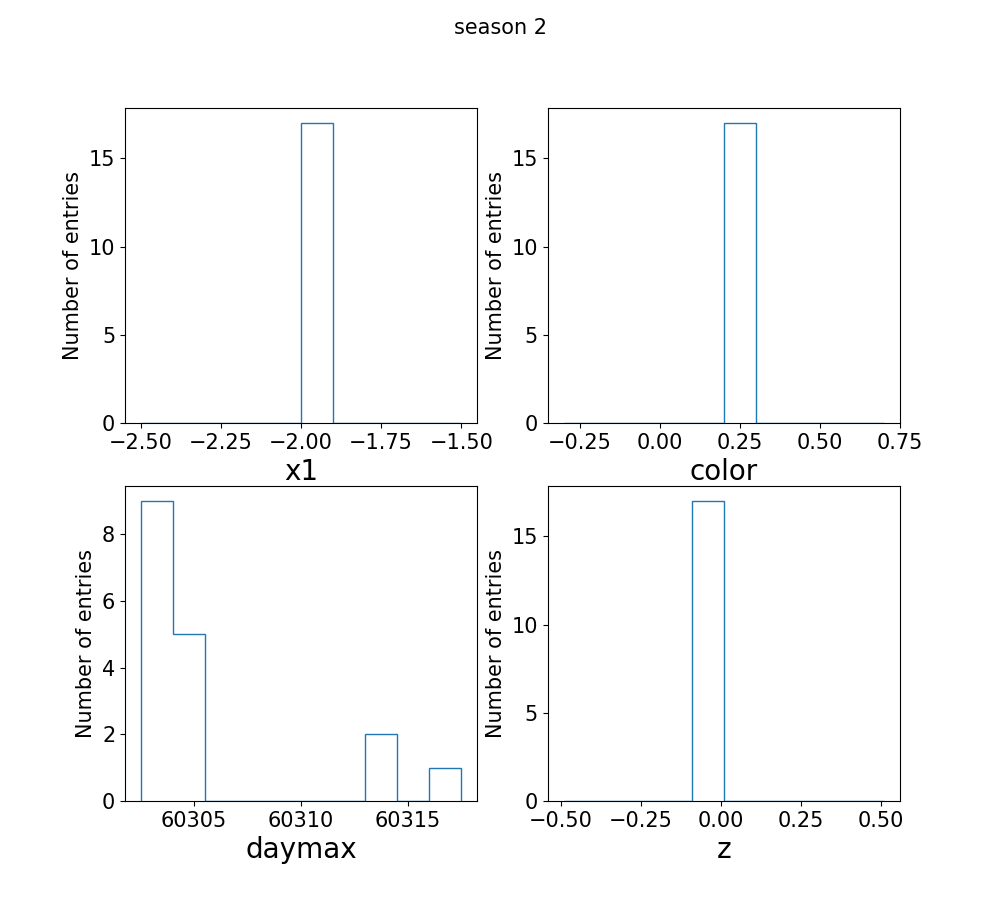

In [21]:
plotParameters(params,season=2)
plt.show()

### Light curves

In [22]:
def plotLC(table,ax,band_id, inum = 0):
    fontsize = 10
    plt.yticks(size=fontsize)
    plt.xticks(size=fontsize)
    for band in 'ugrizy':
        i = band_id[band][0]
        j = band_id[band][1]
        #ax[i,j].set_yscale("log")
        idx = table['band'] == 'LSST::'+band
        sel = table[idx]
        #print('hello',band,inum,len(sel))
        #ax[band_id[band][0]][band_id[band][1]].errorbar(sel['time'],sel['mag'],yerr = sel['magerr'],color=colors[band])
        ax[i,j].errorbar(sel['time'],sel['flux_e_sec'],yerr = sel['flux_e_sec']/sel['snr_m5'],
                         markersize=200000.,color=colors[band],linewidth=1)
        if i > 1:
            ax[i,j].set_xlabel('MJD [day]',{'fontsize': fontsize})
        ax[i,j].set_ylabel('Flux [pe/sec]',{'fontsize': fontsize})
        ax[i,j].text(0.1, 0.9, band, horizontalalignment='center',
             verticalalignment='center', transform=ax[i,j].transAxes)


In [23]:
lcFile = '{}/LC_{}_1.hdf5'.format(config['Output']['directory'],config['ProductionID'])
f = h5py.File(lcFile, 'r')
print(f.keys(),len(f.keys()))

<KeysViewHDF5 ['lc_27238_0.01_59947.5183_1_174_-2.0_0.2_0', 'lc_27238_0.01_60304.5164_2_175_-2.0_0.2_0', 'lc_27238_0.01_60687.4868_3_176_-2.0_0.2_0', 'lc_27238_0.01_61052.4767_4_177_-2.0_0.2_0', 'lc_27238_0.01_61417.4934_5_178_-2.0_0.2_0', 'lc_27238_0.01_61776.4969_6_179_-2.0_0.2_0', 'lc_27238_0.01_62146.4959_7_180_-2.0_0.2_0', 'lc_27238_0.01_62526.4453_8_181_-2.0_0.2_0', 'lc_27238_0.01_62874.4999_9_182_-2.0_0.2_0', 'lc_27238_0.01_63225.523_10_183_-2.0_0.2_0', 'lc_27239_0.01_59937.5213_1_161_-2.0_0.2_0', 'lc_27239_0.01_60304.5164_2_162_-2.0_0.2_0', 'lc_27239_0.01_60670.5221_3_163_-2.0_0.2_0', 'lc_27239_0.01_61038.5227_4_164_-2.0_0.2_0', 'lc_27239_0.01_61398.5213_5_165_-2.0_0.2_0', 'lc_27239_0.01_61765.5224_6_166_-2.0_0.2_0', 'lc_27239_0.01_62137.5073_7_167_-2.0_0.2_0', 'lc_27239_0.01_62507.5022_8_168_-2.0_0.2_0', 'lc_27239_0.01_62867.5179_9_169_-2.0_0.2_0', 'lc_27239_0.01_63225.523_10_170_-2.0_0.2_0', 'lc_27244_0.01_59947.5183_1_151_-2.0_0.2_0', 'lc_27244_0.01_60304.5164_2_152_-2.0_0.2

<IPython.core.display.Javascript object>


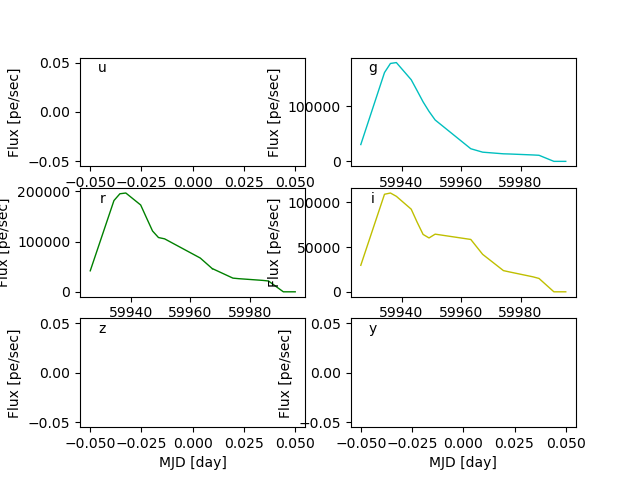

OrderedDict([('Dec', 1.9340522567225311),
             ('RA', 150.11335827925245),
             ('color', 0.2),
             ('dL', 41959.39520882315),
             ('daymax', 59937.521333359844),
             ('ebvofMW', 0.13289982080459595),
             ('epsilon_color', 0.0),
             ('epsilon_daymax', 0.0),
             ('epsilon_x0', 0.0),
             ('epsilon_x1', 0.0),
             ('healpixID', 27239),
             ('pixDec', 0.5968418305070173),
             ('pixRA', 150.46875),
             ('ptime', 0.020868539810180664),
             ('season', 1),
             ('sn_model', 'salt2-extended'),
             ('sn_type', 'SN_Ia'),
             ('sn_version', '1.0'),
             ('snr_fluxsec_meth', 'interp'),
             ('status', 1),
             ('survey_area', 0.8392936452111668),
             ('x0', 0.01979313399461989),
             ('x1', -2.0),
             ('z', 0.01)])
index         m5                time        ... zpsys        phase       
----- ---------

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2020_41/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [24]:
fig, ax = plt.subplots(ncols=2, nrows=3)
bands='ugrizy'
band_id = dict(zip(bands,[(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]))
colors = dict(zip(bands,'bcgyrm'))
for i, key in enumerate(f.keys()):
    lc = Table.read(lcFile, path=key)
    
    if len(lc) > 20:
        pprint.pprint(lc.meta)
        print(lc) # light curve points
        plotLC(lc,ax,band_id,i)
        break